In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q datasets transformers[sentencepiece] simpletransformers

     |████████████████████████████████| 311 kB 9.8 MB/s 
     |████████████████████████████████| 3.5 MB 81.3 MB/s 
     |████████████████████████████████| 248 kB 85.9 MB/s 
     |████████████████████████████████| 67 kB 7.0 MB/s 
     |████████████████████████████████| 133 kB 99.1 MB/s 
     |████████████████████████████████| 243 kB 89.5 MB/s 
     |████████████████████████████████| 1.1 MB 74.6 MB/s 
     |████████████████████████████████| 43 kB 2.7 MB/s 
     |████████████████████████████████| 1.2 MB 82.8 MB/s 
     |████████████████████████████████| 6.8 MB 88.8 MB/s 
     |████████████████████████████████| 9.7 MB 94.2 MB/s 
     |████████████████████████████████| 1.7 MB 97.2 MB/s 
     |████████████████████████████████| 895 kB 79.9 MB/s 
     |████████████████████████████████| 596 kB 74.9 MB/s 
     |████████████████████████████████| 180 kB 77.9 MB/s 
     |████████████████████████████████| 144 kB 80.5 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |███████████████

In [ ]:
! pip install -q simpletransformers

In [ ]:
import torch
import pandas as pd
from simpletransformers.ner import NERModel, NERArgs

In [ ]:
!tar -xzvf "AIFORTHAI-LST20Corpus.tar.gz" -C "/content/"

In [ ]:
from datasets import load_dataset
lst20 = load_dataset("lst20", data_dir="/content/LST20_Corpus")

Downloading:   0%|          | 0.00/2.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

Using custom data configuration default-97621787f5b60e1b


0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset lst20 downloaded and prepared to /root/.cache/huggingface/datasets/lst20/default-97621787f5b60e1b/0.0.0/e1b2a921fb011578ab43ddbbf789f3c500d62cb2df8ae4ed4b60bae8e4c0d3ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
lst20

DatasetDict({
    train: Dataset({
        features: ['id', 'fname', 'tokens', 'pos_tags', 'ner_tags', 'clause_tags'],
        num_rows: 63310
    })
    validation: Dataset({
        features: ['id', 'fname', 'tokens', 'pos_tags', 'ner_tags', 'clause_tags'],
        num_rows: 5620
    })
    test: Dataset({
        features: ['id', 'fname', 'tokens', 'pos_tags', 'ner_tags', 'clause_tags'],
        num_rows: 5250
    })
})

In [ ]:
import pandas as pd
train_df = pd.DataFrame(lst20['train'])
validation_df = pd.DataFrame(lst20['validation'])
test_df = pd.DataFrame(lst20['test'])

In [ ]:
train_df

,id,fname,tokens,pos_tags,ner_tags,clause_tags
0,0,T00126.txt,"[สุรยุทธ์, ยัน, ปฏิเสธ, ลงนาม, _, MOU, _, กับ,...","[0, 1, 1, 1, 2, 0, 2, 4, 0, 12, 1, 0]","[8, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0]","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3]"
1,1,T00126.txt,"[1, _, กันยายน, _, 2550, _, 12:21, _, น.]","[8, 2, 0, 2, 8, 2, 8, 2, 10]","[3, 13, 13, 13, 23, 0, 3, 13, 23]","[1, 2, 2, 2, 2, 2, 2, 2, 3]"
2,2,T00126.txt,"[นายก, ฯ, _, ย้ำ, ไม่, ลงนาม, ใน, _, MOU, _, ร...","[0, 2, 2, 1, 12, 1, 4, 2, 0, 2, 4, 0, 3, 5, 6,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, ...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, ..."
3,3,T00126.txt,"[ยัน, ไทย, ไม่, ได้, ล้มเหลว, ถึง, ขั้น, นั้น,...","[1, 0, 12, 5, 1, 1, 0, 9, 1, 7, 1, 0, 9, 12, 1...","[0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
4,4,T00126.txt,"[พร้อม, หนุน, กกต., จัด, เลือกตั้ง, ให้, บริสุ...","[3, 1, 0, 1, 1, 3, 1, 1]","[0, 0, 7, 0, 0, 0, 0, 0]","[1, 2, 2, 2, 3, 1, 2, 3]"
...,...,...,...,...,...,...
63305,6,T13136.txt,"[นาย, ปณิธาน, _, กล่าว, ว่า, _, หาก, การ, ยื่น...","[0, 0, 2, 1, 3, 2, 3, 7, 1, 0, 12, 1, 3, 5, 1,...","[10, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 2, 2, 2, 3, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, ..."
63306,7,T13136.txt,"[เมื่อ, ถาม, ว่า, _, ใน, ทาง, การเมือง, _, หาก...","[4, 1, 3, 2, 4, 0, 0, 2, 3, 0, 3, 1, 0, 6, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
63307,8,T13136.txt,"[นาย, ปณิธาน, _, กล่าว, ว่า, _, เรื่อง, กฎหมาย...","[0, 0, 2, 1, 3, 2, 0, 0, 5, 3, 1, 2, 7, 1, 1, ...","[10, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
63308,9,T13136.txt,"[หาก, เป็น, การ, ขอ, ถวาย, ฎีกา, ตาม, โบราณ, ร...","[3, 1, 7, 1, 1, 0, 4, 0, 0, 2, 5, 1, 0, 3, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, ...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, ..."


In [ ]:
# See tags from https://github.com/huggingface/datasets/blob/master/datasets/lst20/lst20.py
_POS_TAGS = ["NN", "VV", "PU", "CC", "PS", "AX", "AV", "FX", "NU", "AJ", "CL", "PR", "NG", "PA", "XX", "IJ"]
_NER_TAGS = [
        "O",
        "B_BRN",
        "B_DES",
        "B_DTM",
        "B_LOC",
        "B_MEA",
        "B_NUM",
        "B_ORG",
        "B_PER",
        "B_TRM",
        "B_TTL",
        "I_BRN",
        "I_DES",
        "I_DTM",
        "I_LOC",
        "I_MEA",
        "I_NUM",
        "I_ORG",
        "I_PER",
        "I_TRM",
        "I_TTL",
        "E_BRN",
        "E_DES",
        "E_DTM",
        "E_LOC",
        "E_MEA",
        "E_NUM",
        "E_ORG",
        "E_PER",
        "E_TRM",
        "E_TTL",
    ]
_CLAUSE_TAGS = ["O", "B_CLS", "I_CLS", "E_CLS"]

In [ ]:
def convert_to_simple_transformer_format(df, field_name, tags):
  sentence_id = []
  words = []
  labels = []

  #Limit at 1000 rows for speed.
  for (idx, r) in df[:].iterrows():
    # print(idx)
    for (i, t) in enumerate(r['tokens']):
      # print(i,t)
      sentence_id.append(idx)
      words.append(t)
      labels.append(tags[r[field_name][i]])

  return pd.DataFrame(
      {"sentence_id": sentence_id, "words": words, "labels": labels}
  )


In [ ]:
train_ = convert_to_simple_transformer_format(train_df, "pos_tags", _POS_TAGS)

In [ ]:
train_

,sentence_id,words,labels
0,0,สุรยุทธ์,NN
1,0,ยัน,VV
2,0,ปฏิเสธ,VV
3,0,ลงนาม,VV
4,0,_,PU
...,...,...,...
2714721,63309,การ,FX
2714722,63309,ถอน,VV
2714723,63309,รายชื่อ,NN
2714724,63309,ด้วย,PS


In [ ]:
validation_ = convert_to_simple_transformer_format(validation_df, "pos_tags", _POS_TAGS)
test_ = convert_to_simple_transformer_format(test_df, "pos_tags", _POS_TAGS)

In [ ]:
# Configure the model
model_args = NERArgs()
model_args.train_batch_size = 32
model_args.evaluate_during_training = True
model_args.overwrite_output_dir = True
model_args.num_train_epochs = 10

model = NERModel(
    "distilbert", "Geotrend/distilbert-base-th-cased", args=model_args, use_cuda=torch.cuda.is_available(),cuda_device=0,labels=_POS_TAGS
)

# Train the model
model.train_model(train_, eval_data=validation_)

Some weights of the model checkpoint at Geotrend/distilbert-base-th-cased were not used when initializing DistilBertForTokenClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at Geotrend/distilbert-base-th-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/1979 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/703 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AX seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PU seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: N

Running Epoch 1 of 10:   0%|          | 0/1979 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/703 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/1979 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/703 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/1979 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/703 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/1979 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/703 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/1979 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/703 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/1979 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/703 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/1979 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/703 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/1979 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/703 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/1979 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/703 [00:00<?, ?it/s]

(19790,
 defaultdict(list,
             {'eval_loss': [0.12749553943558956,
               0.12813894047665478,
               0.11438513496409768,
               0.11171799305009035,
               0.10520931062120335,
               0.10706837909911517,
               0.10620859768711942,
               0.10754282449542348,
               0.1063592856721161,
               0.1097799256832056,
               0.109291932893834,
               0.11458300078407944,
               0.11144363732249568,
               0.11314771753230518,
               0.11445679562108374,
               0.1172719657616559,
               0.12024718330263351,
               0.12036032086353521,
               0.12136741615124749],
              'f1_score': [0.9402430943875136,
               0.9391457606255377,
               0.9446955913226032,
               0.9445965652178475,
               0.9488849763204044,
               0.9480411186400297,
               0.9490279280320139,
               0.947985

In [ ]:
# Make predictions with the model
predictions, raw_outputs = model.predict(["ประยุธต์","","กิน","ข้าว"])
predictions

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

[[{'ประยุธต์': 'NN'}], [], [{'กิน': 'VV'}], [{'ข้าว': 'NN'}]]

In [ ]:
test = []
with open('/content/pos_test.txt', encoding='utf8') as f:
    for line in f:
        #print(line.strip())
        test.append(line)

In [ ]:
testRl = []
for i in test:
  testRl.append(i.strip())

In [ ]:
testRl[0:5]


['อย่างไรก็ตาม', 'เครื่อง', 'บิน', 'แอร์บัส', '']

In [ ]:
predictions, raw_outputs = model.predict(testRl)
predictions

  0%|          | 0/5 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/12990 [00:00<?, ?it/s]

[[{'อย่างไรก็ตาม': 'CC'}],
 [{'เครื่อง': 'NN'}],
 [{'บิน': 'VV'}],
 [{'แอร์บัส': 'NN'}],
 [],
 [{'เอ': 'NN'}],
 [{'380': 'NU'}],
 [{'ได้': 'AX'}],
 [{'ถึง': 'PS'}],
 [{'ที่': 'PS'}],
 [{'หมาย': 'NN'}],
 [{'ที่': 'PS'}],
 [{'ท่าอากาศยาน': 'NN'}],
 [{'เชียงใหม่': 'NN'}],
 [{'ใน': 'PS'}],
 [{'เวลา': 'NN'}],
 [],
 [{'14.50': 'NU'}],
 [],
 [{'น.': 'NN'}],
 [{'โดย': 'CC'}],
 [{'ใช้': 'VV'}],
 [{'เวลา': 'NN'}],
 [{'บิน': 'VV'}],
 [{'ประมาณ': 'AJ'}],
 [{'1': 'NU'}],
 [{'ชั่วโมง': 'NN'}],
 [],
 [{'มูลนิธิสืบฯ': 'NN'}],
 [{'พอใจ': 'VV'}],
 [{'ฟื้น': 'VV'}],
 [{'ป่าห้วยขาแข้ง': 'NN'}],
 [{'มี': 'VV'}],
 [{'เสือโคร่ง': 'NN'}],
 [{'มาก': 'VV'}],
 [{'อันดับ': 'NN'}],
 [{'2': 'NU'}],
 [{'โลก': 'NN'}],
 [],
 [{'1': 'NU'}],
 [],
 [{'กันยายน': 'NN'}],
 [],
 [{'2550': 'NU'}],
 [{'17.31': 'NU'}],
 [{'น.': 'NN'}],
 [],
 [{'ประธาน': 'NN'}],
 [{'มูลนิธิ': 'NN'}],
 [{'สืบ': 'VV'}],
 [{'นาคะเสถียร': 'NN'}],
 [{'พอใจ': 'VV'}],
 [{'ป่า': 'NN'}],
 [{'ห้วยขาแข้ง': 'NN'}],
 [{'ฟื้นตัว': 'VV'}],
 [{'พบ': 'VV'}],
 [{

In [ ]:
predictions[0]

[{'อย่างไรก็ตาม': 'CC'}]

In [ ]:
f = open("/content/pos_test.txt", "r")
test_data = f.read()

In [ ]:
test_data = test_data.replace("\n", " ")
test_df = test_data.split(" ")

In [ ]:
for i in range(len(test_df)):
  if test_df[i] == "":
    test_df[i] = " "

In [ ]:
df = pd.DataFrame(data=test_df, columns=["word"])

In [ ]:
df

,word
0,อย่างไรก็ตาม
1,เครื่อง
2,บิน
3,แอร์บัส
4,
...,...
103909,พร้อม
103910,รับ
103911,การ
103912,โจมตี


In [ ]:
def convert_to_key_valuefrom(dic):
  if (dic == None):
    return "O"
  else:
    dic = list(dic.items())[0]
    return dic[0] + "_" + dic[1]

In [ ]:
a = pd.DataFrame(predictions)
a.drop(columns=[1], axis=1, inplace=True)
a

,0
0,{'อย่างไรก็ตาม': 'CC'}
1,{'เครื่อง': 'NN'}
2,{'บิน': 'VV'}
3,{'แอร์บัส': 'NN'}
4,None
...,...
103908,{'เตรียม': 'VV'}
103909,{'พร้อม': 'VV'}
103910,{'รับ': 'VV'}
103911,{'การ': 'FX'}


In [ ]:
a.rename({0:'word'}, axis=1, inplace=True)
a['word'] = a['word'].apply(convert_to_key_valuefrom)

In [ ]:
a['Id'] = a['word'].apply(lambda x:x.split("_")[0])

In [ ]:
a['Predicted'] = a['word'].apply(lambda x:x.split("_")[-1])
a.drop(columns=['word', 'Id'], axis=1, inplace=True)

In [ ]:
a.reset_index(inplace=True)
a['index'] = a['index']+1
a.set_index("index", inplace=True)
a

,Predicted
index,
1,CC
2,NN
3,VV
4,NN
5,O
...,...
103909,VV
103910,VV
103911,VV


In [ ]:
a.to_csv('sun10epochdisbertgeotrend.csv')

In [ ]:
a['Predicted'].value_counts()

NN    30654
VV    24937
O     16794
PS     7060
CC     6614
AX     4259
NU     3247
FX     2739
AJ     1593
PU     1546
AV     1377
CL     1369
NG      994
PR      678
PA       29
IJ       19
XX        4
Name: Predicted, dtype: int64

[ 'AJ', 'AV', 'AX', 'CC', 'CL', 'FX', 'IJ', 'NG', 'NN', 'NU', 'O', 'PA', 'PR', 'PS', 'PU', 'VV', 'XX']

In [ ]:
%cp -av "/content/outputs" "/content/drive/MyDrive/output/output_disbert_wangchan_10epoch/"

cp: cannot create directory '/content/drive/MyDrive/output/output_disbert_wangchan_10epoch/': No such file or directory


In [ ]:
 #a = train_.loc[train_['labels'] == 'XX']

In [ ]:
#a

,sentence_id,words,labels
58047,1906,a,XX
63886,2124,เดอะ,XX
72147,2438,-,XX
74037,2525,ของ,XX
117784,3978,น้ำตาตกใน,XX
...,...,...,...
2578406,59938,กลุย,XX
2578436,59940,ดันดรีม,XX
2680502,62500,แต่อย่าง,XX
2681808,62531,แต่อย่าง,XX


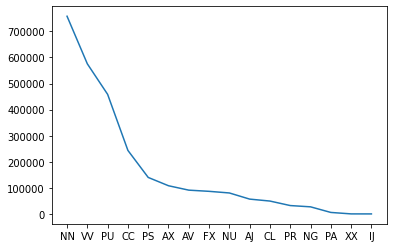

In [ ]:
#import matplotlib.pyplot as plt
#plt.plot(train_['labels'].value_counts())